<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring</p>

---

# 10. Other solutions to the TSP


In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_10/"              # where to look for the data
HTML(custom_css())   

## exercise 10.1

By adapting your Genetic Algorithm (GA) code, developed during the Numerical Exercise 9, write a C++ code to solve the TSP with a **Simulated Annealing** (SA) algorithm. Apply your code to the optimization of a path among 

- 32 cities randomly placed on a circumference
- 32 cities randomly placed inside a square

<p class='assignement'> plot the length of the best path as a function of the iteration of your algorithm, displaying also what the best path looks like. Then compare your SA results with those obtained with GA in the previous numerical exercise.</p>

In [2]:
from ipywidgets import interactive

title = 'Sum of squared distances along the shortest path'
xlabel = 'generation'
ylabel = '$L^{(2)}$'
iterations = 2**16

def plot_length(ax, iteration, shape):
    length = np.loadtxt(results_directory + 'length_' + shape + '.dat')
    L = length[iteration]
    if shape == 'circle':
        label_L = f'${L:.4f}$'
    else:
        label_L = f'${L:.2f}\; L_{{\\rm square}}$'
    ax.plot(length[:iteration], label=f'path length: ' + label_L)
    set_labels(ax, title, xlabel, ylabel)
    ax.legend(loc='center')
    
N = 32
color = 'darkred'    
color_w = 'darkgreen'

def draw_solution(ax, iteration, shape):
    points = np.loadtxt(results_directory + shape + '_points.dat')
    x, y = points[:,0], points[:,1]
    if shape == 'circle':
        xlim = [-1.05, 1.05]
        ylim = [-1.05, 1.05]
    elif shape == 'square':
        xlim = [-0.01, 1.01]
        ylim = [-0.01, 1.01]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(x, y, lw=0.1)
    ax.set_axis_off()
    route = np.loadtxt(results_directory + 'route_' + shape + '.dat', dtype=int)[iteration]
    for i in range(0,N):
        x1, x2, y1, y2 = x[route[i]], x[route[i-1]], y[route[i]], y[route[i-1]]
        ax.plot([x1, x2], [y1, y2], c=color, alpha=0.2)
    
def plot_solution(iteration, shape):
    fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1.3, 1]})
    plot_length(ax[0], iteration, shape)
    draw_solution(ax[1], iteration, shape)
    
#interactive(plot_solution, shape=['circle', 'square'], iteration=(0, iterations-1)) # <- interactive plot

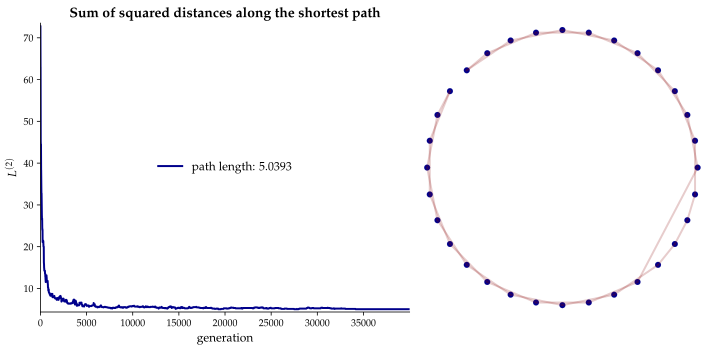

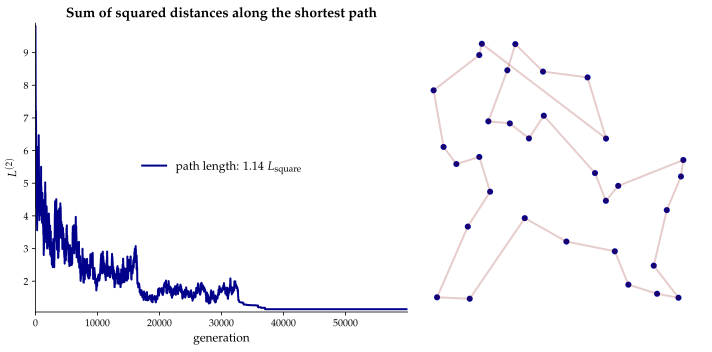

In [3]:
plot_solution(40000, 'circle')
plot_solution(60000, 'square')

Compared to the results obtained in the previous lab, this method does not produce routes as optimized.

## exercise 10.2

Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with 4 **parallel GA searches of the optimal path**.

<p class='remark'>each node should perform an independent GA search the so-called <i>Continents</i>, <b>but</b> every $N_{migr}$ generations the <i>Continent</i> should exchange their best individuals randomly.</p>

<p class='assignement'>Apply your code to the TSP problem for 32 cities randomly placed inside a square and try to estimate if your performances improve with <i>Continents</i>.</p>

In [4]:
from ipywidgets import interactive

title = 'Sum of squared distances along the shortest paths'
xlabel = 'generation'
ylabel = '$L^{(2)}$'
iterations = 2**10
suff = ['th', 'st', 'nd', 'rd']

def plot_parallel_length(ax, iteration, cores):
    for i in range(cores):
        length = np.loadtxt(results_directory + f'mpi_lengths_{cores}_{i}.dat')
        #best_avg = np.loadtxt(results_directory + f'mpi_best_average_{i}.dat')
        L = length[iteration]
        label_L = f'${L:.2f}\; L_{{\\rm square}}$'
        ax.plot(length[:iteration], alpha=0.5, lw=3, label=f'{i}{suff[i]} core: final path length = ' + label_L)
        if i == 0:
            min_length = length
            i_min = 0
        else:
            if length[-1] < min_length[-1]:
                i_min = i
            min_length = np.min([length, min_length], axis=0)
            
    ax.plot(min_length[:iteration], lw=1, ls='--', c='k', label='$L^{(2)}_{min}$')
    set_labels(ax, title, xlabel, ylabel)
    ax.legend(loc='upper right')
    return i_min

N = 32
colors = ['darkred', 'darkorange', 'darkblue', 'darkgrey'] 
color_w = 'darkgreen'

def draw_parallel_solution(ax, iteration, i_min, cores, best=True, worst=False):
    ax.set_axis_off()
    xlim = [-0.01, 1.01]
    ylim = [-0.01, 1.01]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    points = np.loadtxt('../results/lab_09/' + f'square_points.dat')
    x, y = points[:,0], points[:,1]
    ax.scatter(x, y, lw=0.1, zorder=2)
    best_route = np.loadtxt(results_directory + f'mpi_best_routes_{cores}_{i_min}.dat', dtype=int)[iteration]
    worst_route = np.loadtxt(results_directory + f'mpi_worst_routes_{cores}_{i_min}.dat', dtype=int)[iteration]
    for j in range(0, N):
        x1, x2, y1, y2 = x[best_route[j]], x[best_route[j-1]], y[best_route[j]], y[best_route[j-1]]
        ax.plot([x1, x2], [y1, y2], c='darkgrey', alpha=0.5, zorder=1)
        if worst:
            x1, x2, y1, y2 = x[worst_route[j]], x[worst_route[j-1]], y[worst_route[j]], y[worst_route[j-1]]
            ax.plot([x1, x2], [y1, y2], c='darkgreen', alpha=0.2, zorder=2)
    
def plot_parallel_solution(iteration, cores):
    fig, ax = plt.subplots(1, 2, figsize=(9,4), gridspec_kw={'width_ratios': [1.3, 1]})
    i_min = plot_parallel_length(ax[0], iteration, cores)
    draw_parallel_solution(ax[1], iteration, i_min, cores)
    
#interactive(plot_solution, shape=['circle', 'square'], iteration=(0, iterations-1)) # <- interactive plot

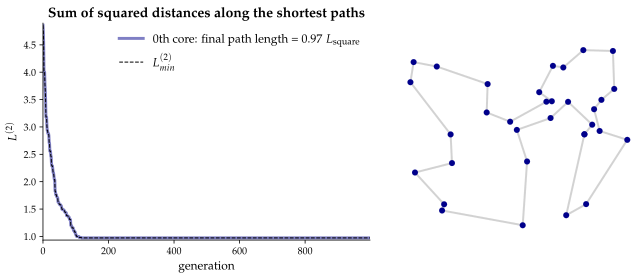

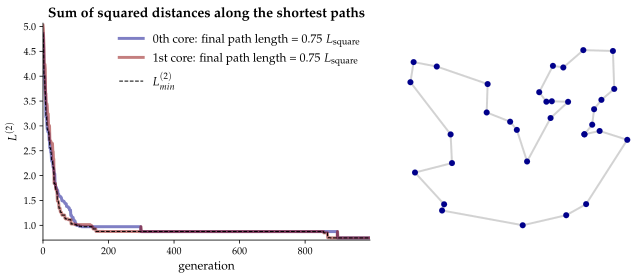

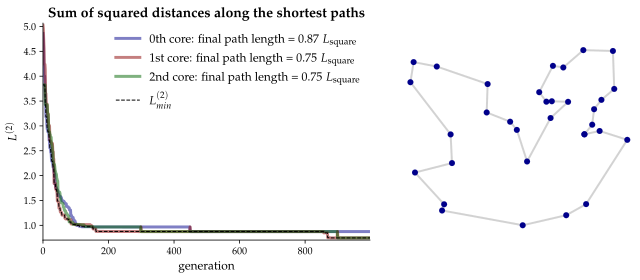

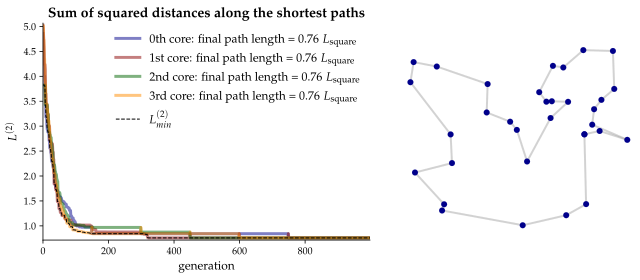

In [5]:
plot_parallel_solution(-1, 1)
plot_parallel_solution(-1, 2)
plot_parallel_solution(-1, 3)
plot_parallel_solution(-1, 4)

The parallelized approach takes more generations to stabilize, probably because the recieved individuals are not always better than the one sent, but as it can use more than one thread, so generally it runs faster than a single-threaded genetic algorithm. The problem of local minima is still present though.